## 04 랜덤 포레스트 
### 랜덤 포레스트 개요 및 실습
- bagging(bootstrap aggregating) : 같은 알고리즘으로 여러 개의 분류기를 만들어 보팅으로 최종 결정하는 알고리즘
- 랜덤 포레스트 : 앙상블 알고리즘 중 비교적 빠른 수행 속도, 높은 예측 성능을 보이는 장점
- 랜덤 포레스트는 결정 트리 알고리즘을 기반으로 함
- 부트스트래핑 : 원래 통계학에서 여러 개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 등의 목적을 위한 샘플링 방식을 지칭. **서브세트의 데이터 건수는 전체 데이터 세트와 동일**하지만, **개별 데이터가 중첩**되어 만들어진다.

- 사이킷런의 RandomForestClassifier 클래스 활용

**사용자 행동 인식 데이터 세트를 RandomForestClassifier를 이용해 예측하기**

In [2]:
### ml_guide_04_Classification(1).ipynb에서 정의한 함수 활용

# 중복된 피처명에 대해 원본 피처명에 _1 또는 _1를 추가 부여하는 함수 생성
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+' '+str(x[1])
                                                                                              if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

import pandas as pd

def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리돼 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./data/human_activity/features.txt', sep='\s+',
                                 header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./data/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./data/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action 적용
    y_train = pd.read_csv('./data/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./data/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


### 랜덤 포레스트 하이퍼 파라미터 및 튜닝
- n_estimators : 랜덤 포레스트에서 결정 트리의 개수 지정 (default : 10)
- max_features : 결정 트리의 max_features와 같으나, default가 None이 아닌 'auto'(=sqrt(전체 피처 개수))
- max_depth나 min_samples_leaf 등 과적합 개선을 위한 파라미터도 적용 가능

**GridSearchCV를 이용한 랜덤 포레스트의 하이퍼 파라미터 튜닝**
- n_estimators = 100, CV = 2로 설정 (튜닝 시간 절약을 위해)
- 다른 하이퍼 파라미터를 최적화한 후, n_estimators를 300으로 증가시켜 예측 성능 평가

In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 : 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


- n_estimators를 300으로 증가시키고, 최적 하이퍼 파라미터 이용해 재학습

In [5]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,
                                min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9165


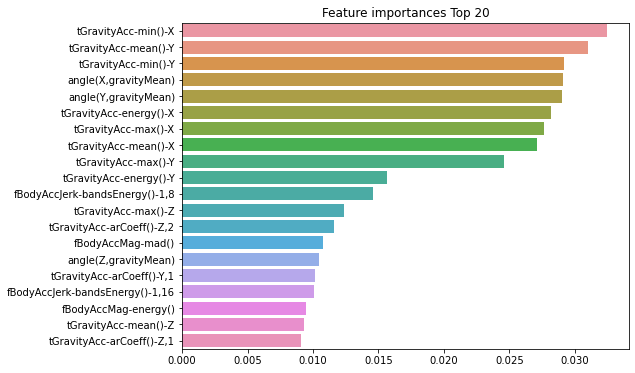

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## 05 GBM(Gradient Boosting Machine)
### GBM의 개요 및 실습
- Boosting Algorithm : 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가며 학습
- AdaBoost(Adaptive boosting) : 오류 데이터에 가중치를 부여하면서 부스팅 수행
- Gradient Boosting : 에이다부스트와 유사하나, 가중치를 경사 하강법(Gradient Descent)을 이용해 업데이트
- GBM은 CART 기반의 다른 알고리즘과 마찬가지로 분류뿐 아니라 회귀도 가능하다.

**사이킷런의 GradientBoostingClassifier 클래스를 활용한 사용자 행동 데이터 예측 분류**

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위한 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행시간 : {0:.1f}초'.format(time.time() - start_time))

GBM 정확도 : 0.9389
GBM 수행시간 : 618.3초


> 예측 정확도 : 93.89%로 이전의 랜덤 포레스트보다 나은 예측 성능
>
> 수행 시간이 더 오래 걸리고, 하이퍼 파라미터 튜닝을 위한 노력이 필요하다는 단점
>
> 약한 학습기의 순차적 예측 오류 보정을 수행하므로, 병렬 처리가 지원되지 않아 대용량 데이터의 경우 학습 시간이 많이 소요된다.

### GBM 하이퍼 파라미터 및 튜닝
- 트리 기반 자체 파라미터인 n_estimators, max_depth, max_features는 이전 내용 참고
- loss : 경사 하강법에서 사용할 비용 함수 지정 (default : deviance)
- learning_rate : 학습률(Weak learner가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수). 0~1 사잇값 지정. n_estimators와 상호 보완적으로 조합해 사용한다.
- n_estimators : weak learner의 개수. 많을 수록 예측 성능이 일정 수준 개선될 수 있지만, 수행 시간 증가 (default : 100)
- subsamples : weak learner가 학습에 사용하는 데이터의 샘플링 비율. (default : 1, 0.5이면 학습 데이터의 50%를 기반으로 학습) 과적합 우려 시 1보다 작게 설정해 사용한다.

In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv=2, verbose = 1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 117.9min finished


최적 하이퍼 파라미터 : 
 {'learning_rate': 0.1, 'n_estimators': 500}
최고 예측 정확도 : 0.9011


> learning_rate가 0.1, n_estimators가 500일 때 2개의 교차 검증 세트에서 최고 정확도 0.9011 도출

In [10]:
# GridSearchCV를 이용해 최적으로 학습된 위의 estimator 토대로 테스트 데이터 세트에 적용해 예측 정확도 확인
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

GBM 정확도 : 0.9420


## 06 XGBoost(eXtra Gradient Boost)
### XGBoost 개요
- 트리 기반의 앙상블 학습에서 가장 각광받는 알고리즘
- 분류에 있어 일반적으로 다른 머신러닝보다 뛰어난 예측 성능 도출
- GBM에 기반하나, GBM의 단점인 느린 수행 시간 및 과적합 규제(Regularization) 부재 등의 문제를 해결
- tree pruning으로 더 이상 긍정 이득이 없는 분할을 가지치기해서 분할 수를 줄이는 추가적인 장점
- 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증 수행해 최적화된 수행 횟수 도출 가능
- 지정된 반복 횟수가 아니라 교차 검증을 통해 평가 데이터 세트의 평가 값이 최적화되면 반복을 중간에 멈출 수 있는 조기 중단 기능
- 결손값 자체 처리 가능

- 파이썬 래퍼 XGBoost 모듈 : 초기 모듈로 고유의 API와 하이퍼 파라미터 이용
- Scikit-learn Wrapper XGBoost 모듈 : 사이킷런의 다른 Estimator와 사용법 동일 -> XGBClassifier, XGBRegressor

### XGBoost 설치하기
- conda install -c anaconda py-xgboost

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
- 사이킷런과 조금 다른 고유의 파라미터 사용. 아래에 정리

**주요 일반 파라미터** : 일반적으로 실행 시 스레드 개수나 silent 모드 등 선택을 위한 파라미터. 보통 Default 값 사용.
- booster : gbtree(tree based model) 또는 gblinear(linear model) 선택. (Default : gbtree)
- silent : 출력 메시지 여부 (Default : 0, 메시지 생략은 1)
- nthread : CPU의 실행 스레드 개수 조정 (Default : 전체 스레드 사용)

**주요 부스터 파라미터** : 트리 최적화, 부스팅, regularization 등과 관련된 파라미터
- eta [default=0.3, alias : learning_rate] : GBM의 학습률(learning rate)과 같은 파라미터
- num_boost_rounds : GBMdml n_estimators와 같은 파라미터
- min_child_weight [default=1] : 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weight 총합.
- gamma [default=0, alias : min_split_loss] : 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값.
- max_depth [default=6] : 0을 지정하면 깊이 제한 없음. 너무 높으면 과적합 발생. 보통 3~10 사이의 값 적용.
- sub_sample [default=1] : GBM의 subsample과 동일. 과적합 제어를 위한 샘플링 비율 지정. 0.5로 지정하면 전체 데이터의 절반을 트리 생성에 사용
- colsample_bytree [default=1] : GBM의 max_features. 트리 생성에 필요한 피처를 임의로 샘플링.
- lambda [default=1, alias : reg_lambda] : L2 Regularization 적용 값. 피처 개수가 많을 경우 적용하며 클수록 과적합 감소 효과
- alpha [default=0, alias : reg_alpha] : L1 Regularization 적용 값. 피처 개수가 많을 경우 적용하며 클수록 과적합 감소 효과
- scale_pos_weight [default=1] : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형 유지를 위한 파라미터.

**학습 태스크 파라미터** : 학습 수행 시의 객체 함수, 평가를 위한 지표 등 설정하는 파라미터
- objective : 최솟값을 가져야 할 손실 함수 정의. XGBoost는 많은 유형의 손실함수를 사용한다.
- binary:logistic : 이진 분류일 때 적용
- multi:softmax : 다중 분류일 때 적용. 손실함수가 multi:softmax일 경우에는 레이블 클래스 개수인 num_class 파라미터 지정 필요
- multi:softprob : 위와 유사하나 개별 레이블 클래스의 해당되는 예측 확률을 반환
- eval_metric : 검증에 사용되는 함수를 정의. 기본값은 회귀의 경우 rmse, 분류일 경우 error. 아래는 값 유형
> - rmse : Root Mean Square Error
> - mae : Mean Absolute Error
> - logloss : Negative log-likelihood
> - error : Binary classification error rate (0.5 threshold)
> - merror : Multiclass classification error rate
> - mlogloss : Multiclass logloss
> - auc : Area Under the Curve

**과적합 문제 발생 시 다음과 같이 적용할 수 있다.**
- eta 값을 낮춘다(0.01 ~ 0.1) : eta 값을 낮출 경우 num_round(또는 n_estimators)는 반대로 높여줘야 한다.
- max_depth 값을 낮춘다.
- min_child_weight 값을 높인다.
- gamma 값을 높인다.
- subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 효과가 있다.

**Early Stopping**
- n_estimators를 200으로 설정하고 조기 중단 파라미터를 50으로 설정하면, 200회 반복하는 중에 50회 동안 학습 오류가 감소하지 않을 시 부스팅 종료

In [12]:
# XGBoost 버전 확인
import xgboost
print(xgboost.__version__)

1.4.2


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
- load_breast_cancer : 사이킷런에 내장된 위스콘신 유방암 데이터 세트로, 악성/양성 여부 예측
> - malignant tumor : 악성 종양
> - benign tumor : 양성 종양

- plot_importance : xgboost 패키지가 제공하는 피처 중요도 시각화 모듈

In [13]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [15]:
# target label 값의 종류는 malignant가 0, benign이 1 값으로 구성
# 레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [16]:
# 전체 데이터 중 80%는 학습용, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


**DMatrix**
- XGBoost만의 전용 데이터 세트. 주요 입력 파라미터는 data와 label.
- 판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차 변환한 뒤, 이를 이용해 DMatrix 변환

In [17]:
# 넘파이 형태의 학습/테스트 데이터 세트를 DMatrix로 변환하기
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [18]:
# XGBoost의 하이퍼 파라미터 설정
params = {'max_depth':3,
         'eta':1,
         'objective':'binary:logistic',
         'eval_metric':'logloss',
         'early_stoppings':100}
num_rounds = 400

- XGBoost는 하이퍼 파라미터를 xboost 모듈의 train() 함수에 파라미터로 전달한다. (사이킷런의 경우 Estimator 생성자를 하이퍼 파라미터로 전달)
- 조기 중단 : xgboost의 train() 함수에 early_stopping_rounds 파라미터를 입력하여 설정
- 조기 중단 수행 시, eval_set과 eval_metric이 함께 설정돼야 한다.

In [20]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기한다.
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds, 
                     early_stopping_rounds=100, evals=wlist)

[03:32:54] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.18867	eval-logloss:0.23481
[1]	train-logloss:0.09020	eval-logloss:0.17512
[2]	train-logloss:0.05316	eval-logloss:0.14435
[3]	train-logloss:0.03499	eval-logloss:0.12218
[4]	train-logloss:0.02482	eval-logloss:0.13251
[5]	train-logloss:0.01805	eval-logloss:0.12932
[6]	train-logloss:0.01483	eval-logloss:0.12959
[7]	train-logloss:0.01196	eval-logloss:0.13830
[8]	train-logloss:0.01038	eval-logloss:0.13207
[9]	train-logloss:0.00933	eval-logloss:0.12440
[10]	train-logloss:0.00864	eval-logloss:0.12573
[11]	train-logloss:0.00829	eval-logloss:0.12642
[12]	train-logloss:0.00779	eval-logloss:0.12878
[13]	train-l

**완료된 학습을 이용해 테스트 데이터 세트 예측 수행**
- 파이썬 래퍼 XGBoost는 train() 함수를 호출해 학습이 완료된 모델 객체를 반환하는데, 이 모델 객체는 예측을 위해 predict() 메서드를 이용.
- 사이킷런의 predict() 메서드는 예측 결과 클래스 값(즉 0,1)을 반환하는 데 반해, xgboost의 predict()는 예측 결과를 추정할 수 있는 확률 값을 반환.

In [21]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 : ', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.898 0.006 0.802 0.012 0.995 1.    1.    1.    0.999 0.   ]
예측값 10개만 표시 :  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [25]:
# get_clf_eval() 함수를 적용해 예측 성능 평가 (테스트 실제 레이블 값을 갖는 y_test와 예측 레이블인 preds를 인자로 입력)
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬 : ')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_probs)

오차 행렬 : 
[[33  4]
 [ 1 76]]
정확도 : 0.9561, 정밀도 : 0.9500, 재현율 : 0.9870,     F1 : 0.9682, AUC:0.9912


**XGBoost 내장 시각화 기능 수행**
plot_importance() API : 피처의 중요도를 막대그래프 형식으로 출력
- 기본 평가 지표로 f1 스코어를 기반으로 각 피처의 중요도 표시
- 유의사항 : xgboost 넘파이 기반의 피처 데이터로 학습 시 피처명을 제대로 알 수 없으므로, f0, f1과 같이 피처 순서별로 순서를 부여해 X축에 나열

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

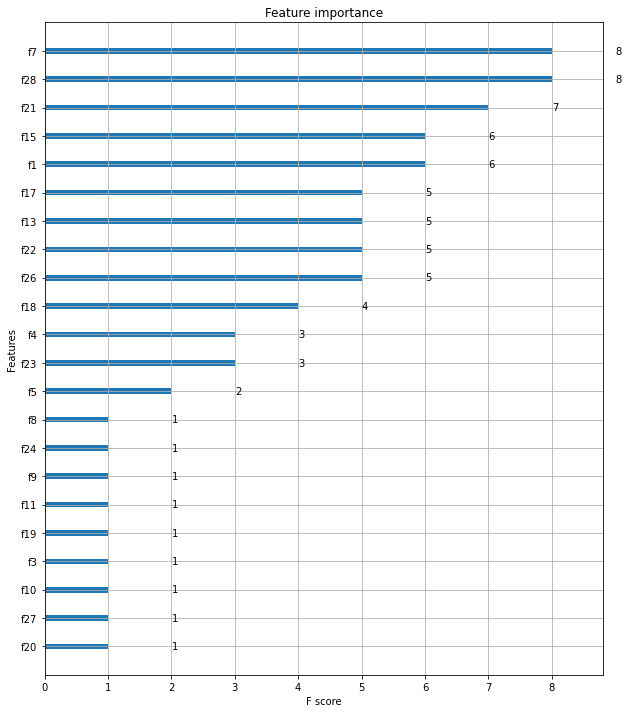

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

- 교차 검증 수행 후 최적 파라미터를 구하는 방법 : cv() API 사용
> xgboost.cv([params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)

### 사이킷런 래퍼 XGBoost의 개요
- 사이킷런의 기본 Estimator를 상속해 만들었기 때문에 fit()과 predict()만으로 학습과 예측 가능
- XGBClassifier : 분류를 위한 래퍼 클래스
- XGBRegression : 회귀를 위한 래퍼 클래스
- eta -> learning_rate
- sub_sample -> subsample
- lambda -> reg_lambda
- alpha -> reg_alpha


### 사이킷런 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [28]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[15:53:13] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
# 성능 평가
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬 : 
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870,     F1 : 0.9806, AUC:0.9951


**early_stopping_rounds (with eval_metric, eval_set) 활용**
- 성능 평가를 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야 한다.
- 아래 예제에서는 전체 데이터 세트의 크기가 작아 테스트 데이터 세트로 평가를 수행했지만, 원래 테스트 데이터 세트는 학습 시에는 완전히 알려지지 않은 데이터 세트를 사용해야 한다. 평가에 테스트 데이터 세트를 사용하면 학습 시에 미리 참고가 되어 과적합이 발생한다.

In [30]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
               eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [32]:
# 조기 중단으로 학습된 XGBClassifier의 예측 성능 확인
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬 : 
[[34  3]
 [ 1 76]]
정확도 : 0.9649, 정밀도 : 0.9620, 재현율 : 0.9870,     F1 : 0.9744, AUC:0.9954


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

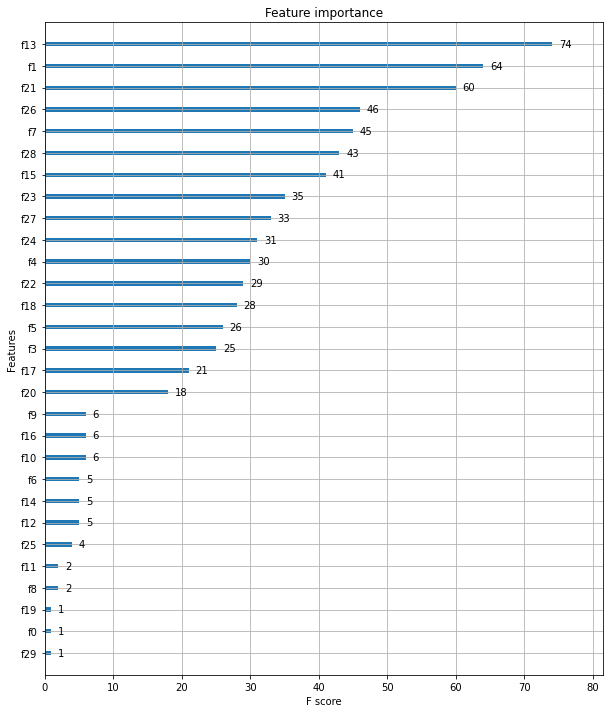

In [33]:
# 피처 중요도 시각화
# 사이킷런 XGBoost 클래스에서도 plot_importance() API를 적용할 수 있다.
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## 07 LightGBM
> LightGBM의 장점
> - XGBoost보다 학습 시간이 적게 소요되며, 메모리 사용량도 적다는 것이 장점
> - 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적 변환하고 노드 분할 수행)
> - 다양한 기능

### LightGBM 설치
- conda install -c conda-forge lightgbm